Import numpy and pandas

In [1]:
import numpy as np
np.random.seed(0)
import pandas as pd
import matplotlib.pyplot as plt
import requests
import json
from io import StringIO
from copy import copy

Let's import sklearn models

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Lasso, LassoCV, ElasticNetCV
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import StandardScaler, scale, Binarizer
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, validation_curve
from sklearn.feature_selection import SelectFromModel
from sklearn.inspection import plot_partial_dependence
from sklearn.decomposition import PCA
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve

And import Keras

In [3]:
from keras import models
from keras import layers
from keras import optimizers

And also LIME

In [4]:
from lime.lime_tabular import LimeTabularExplainer

Download json files used to create feature names and columns for dataset

In [5]:
resp = requests.get('https://raw.githubusercontent.com/VincenzoNucci/MachineLearningFromScratch/master/cards.json')
cards = resp.json()
resp = requests.get('https://raw.githubusercontent.com/VincenzoNucci/MachineLearningFromScratch/master/relics.json')
relics = resp.json()
characters_dict = {
  'IRONCLAD':1,
  'THE_SILENT':2,
  'DEFECT':3,
  'WATCHER':4
}
print(cards['Adrenaline'])
cards_columns = list(cards.keys())
# Handle renamed relics by adding them as a list
relics_columns = list(relics.keys()) + ['Wing Boots']

{'NAME': 'Adrenaline', 'DESCRIPTION': 'Gain [G]. NL Draw 2 cards. NL Exhaust.', 'UPGRADE_DESCRIPTION': 'Gain [G] [G]. NL Draw 2 cards. NL Exhaust.'}


Create the actual feature names

In [6]:
# Add the upgraded card for each card as column
for card_name in copy(cards_columns):
    cards_columns.append(card_name+'+1')

# finalize the columns to use as feature names
columns = [
    'gold_spent',
    'floor_reached',
    'total_damage_taken',
    'total_cards',
    'total_relics',
    'campfires_num',
    'items_purged_num',
    'potions_used_num',
    'character_chosen',
    'items_purchased_num',
    'campfire_rested_num',
    'campfire_upgraded_num',
    'victory'] + cards_columns + relics_columns

Create a pandas DataFrame of the dataset, while dropping 'unnecessary' columns

In [7]:
# Data comes from Slay the Spire matches recorded through game replay utility, collected by spirelogs.com website and openly available for research
# Slay the Spire is a deck building roguelike videogame in which the player selects a character and embarks in three different acts (stages of the game).
# Fundamentals to the game are battles taking place along the path the player choses. At the end of the battle the player is rewarded with one of three card of his choice

# load the new no index data
sts_data = requests.get('https://raw.githubusercontent.com/VincenzoNucci/MachineLearningFromScratch/master/notebook/dataset/sts_data.csv').text
sts_data = StringIO(sts_data)
# we did it boys, index is no more
df = pd.read_csv(sts_data,header=0)

# drop columns that I think will affect negatively classification
X_df = df.drop(labels=['floor_reached','total_damage_taken','total_cards','total_relics','campfires_num','victory'],axis=1)
X = X_df.to_numpy()

y_df = df['victory']
y = y_df.to_numpy()

X_original = np.copy(X)
X_original_columns = X_df.columns
X = StandardScaler().fit_transform(X)

#discrete_binarizer = Binarizer(threshold=0)
#continuous_binarizer = Binarizer(threshold=X_df['gold_spent'].mean())
#X_bin = continuous_binarizer.fit_transform(X_original)
#X_bin = discrete_binarizer.fit_transform(X_bin)

# There are 23802 samples of Slay the Spire matches. Each match is described by the counters that the game keeps track of and the cards that the player bought/received
# totaling 1049 features. However the nature of the matrix is sparse.
print(X.shape)
print(X_df.head())

(23802, 1049)
   gold_spent  items_purged_num  potions_used_num  character_chosen  \
0         110                 0                 5                 2   
1          21                 0                 5                 2   
2         113                 0                 4                 3   
3          51                 4                 0                 1   
4          11                 2                 6                 1   

   items_purchased_num  campfire_rested_num  campfire_upgraded_num  \
0                    1                    4                      5   
1                    2                    1                      9   
2                    7                    4                      0   
3                    6                    5                      2   
4                    5                    3                      3   

   A Thousand Cuts  Accuracy  Acrobatics  ...  CeramicFish  SlaversCollar  \
0                0         0           0  ...            0   

Binarize dataset for Restricted Boltzmann Machine and for other tries

In [8]:
#convert features to binary features by creating a mask in the dataframe and substitute
#values > 0 is 1 and values <= 0 is 0

#for cards, relics and counters, 1 means the element is in play/been used
col_discrete_binary = cards_columns + relics_columns
X_df_binary = (X_df[col_discrete_binary] > 0).astype(int)

#for continuous features, 1 means having spent more than the average
#for discrete features, 1 means having spent more than the median
avg_gold_spent = np.floor(X_df['gold_spent'].mean())
avg_potions_used = np.floor(X_df['potions_used_num'].median())
avg_items_purged = np.floor(X_df['items_purged_num'].median())
avg_items_purchased = np.floor(X_df['items_purchased_num'].median())
avg_campfire_rested = np.floor(X_df['campfire_rested_num'].median())
avg_campfire_upgraded = np.floor(X_df['campfire_upgraded_num'].median())

X_df_binary['gold_spent'] = (X_df['gold_spent'] >= avg_gold_spent).astype(int)
X_df_binary['potions_used_num'] = (X_df['potions_used_num'] >= avg_potions_used).astype(int)
X_df_binary['items_purged_num'] = (X_df['items_purged_num'] >= avg_items_purged).astype(int)
X_df_binary['items_purchased_num'] = (X_df['items_purchased_num'] >= avg_items_purchased).astype(int)
X_df_binary['campfire_rested_num'] = (X_df['campfire_rested_num'] >= avg_campfire_rested).astype(int)
X_df_binary['campfire_upgraded_num'] = (X_df['campfire_upgraded_num'] >= avg_campfire_upgraded).astype(int)

#transform character chosen into 4 different binary columns
X_df_binary = pd.concat([X_df_binary,pd.get_dummies(X_df['character_chosen'],prefix='character')],axis=1)

print(X_df_binary.head())

X_binary = X_df_binary.to_numpy() #1052 features

   A Thousand Cuts  Accuracy  Acrobatics  Adrenaline  After Image  Aggregate  \
0                0         0           0           0            0          0   
1                0         0           0           0            0          0   
2                0         0           0           0            0          1   
3                0         0           0           0            0          0   
4                0         0           0           0            0          0   

   All For One  All Out Attack  Allocate  Amplify  ...  gold_spent  \
0            0               0         0        0  ...           1   
1            0               0         0        0  ...           0   
2            0               0         0        0  ...           1   
3            0               0         0        0  ...           0   
4            0               0         0        0  ...           0   

   potions_used_num  items_purged_num  items_purchased_num  \
0                 1                 

Data is sparse matrix, try feature selection with different models (LASSO, SVM and RBM) + Logistic Regression

In [9]:
from sklearn.neural_network import BernoulliRBM

X_train, X_test, y_train, y_test = train_test_split(X_binary,y,train_size=0.9,random_state=0)

lasso = LassoCV(random_state=0,tol=1e-4,max_iter=1000)
lasso = lasso.fit(X_train,y_train)
print(lasso.score(X_test,y_test))

# with binarized data svm converges faster and needs less iterations
svm = LinearSVC(random_state=0,penalty='l1',C=100,tol=1e-04,dual=False,max_iter=1000)
svm.fit(X_train,y_train)
print(svm.score(X_test,y_test))

logreg = LogisticRegression(random_state=0,max_iter=1000)
logreg = logreg.fit(X_train,y_train)
scores = cross_val_score(logreg, X_test, y_test, cv=5)
print(scores.mean())

# Do not use RBM to improve accuracy while reducing features. Being a high dimensional dataset with lots of 'variables', reducing the features to a number such as 10 it doesn't work
#rbm = BernoulliRBM(n_components=10,learning_rate=0.01,n_iter=10,random_state=0)
# New data will have 100 feature exact, but unable to link back which features have been selected
#X_rbm = rbm.fit_transform(X_binary)

0.7358577927533093
0.9433011339773204
0.9147416151211217


Now use the feature selected by SVM for Random Forest Classifier

In [11]:
svm_model = SelectFromModel(svm,prefit=True)
X_svm = svm_model.transform(X_binary)
features_idx = svm_model.get_support()
# number of features extracted from model
feature_names = X_df_binary.columns[features_idx]
# features that survived the regularization
feature_names = list(feature_names)
print('new features size from svm:',len(feature_names))

X_df_svm = pd.DataFrame(X_svm,columns=feature_names)

X_svm_scaled = StandardScaler().fit_transform(X_svm)

new features size from svm: 879


Reduce dimensionality also with PCA and RBM (but with RBM we lose intepretability)

In [14]:
from sklearn.decomposition import PCA, SparsePCA #and use alpha from Lasso

pca = PCA(n_components=0.95,random_state=0)
sparse_pca = SparsePCA(n_components=10,random_state=0,alpha=lasso.alpha_,n_jobs=-1)
X_svm_pca = pca.fit_transform(X_svm)
pca.explained_variance_ratio_.sum()


0.9500227701178575

In [12]:
rf_rbm = RandomForestClassifier(n_estimators=500, random_state=0, max_depth=5, criterion='gini')
rf_rbm.fit(X_rbm_train, y_rbm_train)
print(rf_rbm.score(X_rbm_test, y_rbm_test))

0.8496430071398572


In [ ]:
def permutation_importances(model, X, y, metric):
    import numpy as np 
    #estimate the original model error
    baseline = metric(model, X, y)
    fi = []
    #for each feature j=1,...,p do
    for col in X.columns:
        save = X[col].copy()
        #permute feature j in data matrix
        X[col] = np.random.permutation(X[col])
        #estimate error on permuted data
        m = metric(model, X, y)
        X[col] = save
        #calculate permutation feature importance FI^j
        #both difference and fraction can be used
        # fi.append(m / baseline)
        fi.append(m - baseline)
    #sort features by descending FI
    return np.array(sorted(fi))

In [ ]:
from sklearn.metrics import auc, roc_curve

def auc_metric(model, X, y):
  y_pred = model.predict_proba(X)
  fpr, tpr, threshold = roc_curve(y, y_pred, pos_label=1)
  return 1 - auc(fpr, tpr)

Train a Random Forest Classifier on SVM extracted data for the sake of LIME (currently supports only predict_proba)

In [19]:
X_tr_lime, X_te_lime, y_tr_lime, y_te_lime = train_test_split(X,y,train_size=0.9,random_state=0)
#_, unscaled_X_test, _, _ = train_test_split(X_lasso,y,train_size=0.8,random_state=0)
# Random Forest performs worse than SVM with features selected
# gini better criterion than information gain
rf = RandomForestClassifier(n_estimators=500, random_state=0, max_features='auto',max_depth=5, criterion='gini')
rf.fit(X_tr_lime,y_tr_lime)
# same as using accuracy_score
print(rf.score(X_te_lime,y_te_lime))

# train RF on binarized data, more or less same values than trained from SVM but more features
#print(rf.fit(X_train,y_train).score(X_test,y_test))

# train on original data gives 3% more accuracy, but to me is difficult to interpret values with LIME afterwards
#X_tr_original, X_te_original, y_tr_original, y_te_original = train_test_split(X_original,y,train_size=0.8,random_state=0)
#print(rf.fit(X_tr_original, y_tr_original).score(X_te_original,y_te_original))

0.9168416631667367


In [20]:
# index of a point in test data
i = 123

# is the point a victory or defeat?
print(y_te_lime[i])
named_instance = [(tag,value) for tag,value in zip(feature_names,X_te_lime[i]) if value > 1e-3]
print(named_instance[:10])

1
[('A Thousand Cuts', 0.16294693299952884), ('After Image', 1.585573197473676), ('Aggregate', 0.023220132834440313), ('All For One', 0.4022318609696264), ('Barrage', 1.0387294738358581), ('Blizzard', 1.869866673583542), ('Blood for Blood', 3.003023517394603), ('Creative AI', 3.5278621942365977), ('Deep Breath', 4.715052958180142), ('Dual Wield', 4.921563423767969)]


In [ ]:
#feature importances from sklearn ensemble estimators are biased
sorted(zip(feature_names,rf.feature_importances_),key=lambda z: z[1], reverse=True)[:10]

from sklearn.inspection import permutation_importance
feature_importances = permutation_importance(rf,X_tr_lime,y_tr_lime,n_repeats=5,random_state=0,n_jobs=-1)
print(sorted(zip(feature_names,feature_importances['importances_mean']),key=lambda z : z[1], reverse=True)[:10])

In [59]:
print(f'actual model prediction {rf.predict_proba(X_te_lime)[i]}')
explainer = LimeTabularExplainer(training_data=X_tr_lime, training_labels=y_tr_lime,feature_names=feature_names,discretize_continuous=False,class_names=['defeat','victory'])
explanation = explainer.explain_instance(X_te_lime[i], rf.predict_proba, num_features=10, distance_metric='minkowski')
explanation.show_in_notebook(show_table=True,show_all=False)

actual model prediction [0.32924315 0.67075685]


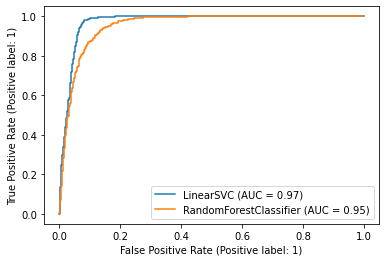

In [61]:
fig, ax = plt.subplots()
plot_roc_curve(svm, X_test, y_test,ax=ax)
plot_roc_curve(rf,X_te_lime,y_te_lime,ax=ax)

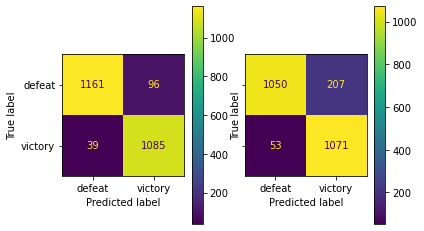

In [66]:
fig, (ax1, ax2) = plt.subplots(1,2,sharey=True)
plot_confusion_matrix(svm, X_test, y_test, display_labels=['defeat','victory'],ax=ax1)
plot_confusion_matrix(rf,X_te_lime,y_te_lime,display_labels=['defeat','victory'],ax=ax2)

In [33]:
from scipy.stats import pearsonr
#These are conclusions drawn from previous instance for which I forgot to save the index (I know...)
#print(f'upgrading more than {avg_campfire_upgraded} cards has a positive impact on victory')
#print(f'having too many copies (remember game starts with 5) of Strike_G card affects negatively the victory')
#print(f'I think this is correlated with the number of purged items, the more Strike_G I remove, the less it will impact negatively the victory')
#print(f'Storm of Steel+1 had a negative impact, but we should verify the deck archetype the player was following')
# Storm of Steel is used on Shiv deck archetypes thus it having a bad impact may underline the fact that the player was not following that archetype
# but nevertheless picked that card

#LIME for instance i=123
#Does having Relic Anchor increase victory? How much is this increase?
coef, pvalue = pearsonr(X_df_binary['Anchor'],y_df)
print(coef, pvalue < 0.05)

0.23927761270927567 True


Check correlation between Strike_G and items_purged_num

In [34]:
from scipy.stats import pearsonr

coef, pvalue = pearsonr(X_df_binary['items_purged_num'],X_df_binary['Strike_G'])
print(coef, pvalue < 0.05)
# It seems that the coefficient says "The more I purge, the less copies of Strike_G I have", so maybe players tend to purge Strike cards?
# It will be better to look to h-statistics and check interaction

-0.1650875500304671 True


In [67]:
#!pip install pycebox
#from pycebox.ice import ice, ice_plot
#ice_df = ice(X_df_svm,'Strike_G',rf.predict)
#ice_plot(ice_df) #binary dataset is not a good alternative for ICE plots, better use the one with continuous variables
#ICE plot needs the attribute 'kind' on plot_partial_dependence
plot_partial_dependence(rf, X_tr_lime, features=feature_names, kind='both',feature_names=feature_names)
#Having copies of Strike_G causes small decrease in victory probability
#Victory percentage is proportional to the number of purged cards. Smaller decks are prone to win more than decks with lots of cards
coef, pvalue = pearsonr(X_df_binary['items_purged_num'],y_df)
print(coef, pvalue < 0.05)
#But Strike_G pdp may also be an indication that Strike_G is interacting with something and it doesn't seem to be items_purged_num becuase it has a clearer pdp
#https://blog.macuyiko.com/post/2019/discovering-interaction-effects-in-ensemble-models.html


0.44921799738137014 True
Error in callback <function flush_figures at 0x00000149E00C7280> (for post_execute):
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

Traceback (most recent call last):
  File "f:\Unicam\master-thesis\lib\site-packages\IPython\core\events.py", line 88, in trigger
    func(*args, **kwargs)
  File "f:\Unicam\master-thesis\lib\site-packages\ipykernel\pylab\backend_inline.py", line 121, in flush_figures
    return show(True)
  File "f:\Unicam\master-thesis\lib\site-packages\ipykernel\pylab\backend_inline.py", line 41, in show
    display(
  File "f:\Unicam\master-thesis\lib\site-packages\IPython\core\display.py", line 313, in display
    format_dict, md_dict = format(obj, include=include, exclude=exclude)
  File "f:\Unicam\master-thesis\lib\site-packages\IPython\core\formatters.py", line 180, in format
    data = formatter(obj)
  File "<decorator-gen-2>", line 2, in __call__
  File "f:\Unicam\master-thesis\li

['Bag of Preparation', 'Bronze Scales', 'Oddly Smooth Stone', 'Red Mask', 'gold_spent', 'potions_used_num', 'items_purged_num', 'items_purchased_num', 'campfire_rested_num', 'campfire_upgraded_num']


<BarContainer object of 879 artists>

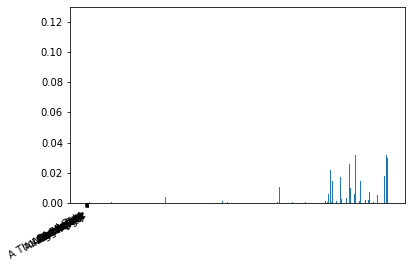

In [59]:
fig, ax = plt.subplots()
important_features = [feature_names[i] for i in range(len(rf.feature_importances_)) if rf.feature_importances_[i] >= 0.02]
print(important_features)
plt.xticks(range(len(important_features)),feature_names)
fig.autofmt_xdate()
ax.bar(range(len(rf.feature_importances_)),rf.feature_importances_)

In [ ]:
mlp = models.Sequential()
mlp.add(layers.Dense(128,input_shape=(100,),activation='relu'))
mlp.add(layers.Dense(256,activation='relu'))
mlp.add(layers.Dense(64,activation='relu'))
mlp.add(layers.Dense(1,activation='softmax'))

mlp.compile(optimizer=optimizers.Adam(1e-3),loss='binary_crossentropy',metrics=['accuracy'])
history = mlp.fit(X_train_rbm,y_train_rbm,batch_size=100,epochs=200,validation_data=(X_test_rbm,y_test_rbm))
score = mlp.evaluate(X_test_rbm,y_test_rbm)
print(score)

SyntaxError: ignored

0.8559428811423772


[Text(744.0, 1304.6399999999999, 'items_purchased_num <= 0.5\ngini = 0.499\nsamples = 21421\nvalue = [11255, 10166]\nclass = defeat'),
 Text(372.0, 1014.72, 'campfire_upgraded_num <= 0.5\ngini = 0.189\nsamples = 8722\nvalue = [7801, 921]\nclass = defeat'),
 Text(186.0, 724.8, 'Madness <= 0.5\ngini = 0.023\nsamples = 6118\nvalue = [6048, 70]\nclass = defeat'),
 Text(93.0, 434.8800000000001, 'Secret Weapon <= 0.5\ngini = 0.017\nsamples = 6075\nvalue = [6022, 53]\nclass = defeat'),
 Text(46.5, 144.96000000000004, '\n  (...)  \n'),
 Text(139.5, 144.96000000000004, '\n  (...)  \n'),
 Text(279.0, 434.8800000000001, 'Orichalcum <= 0.5\ngini = 0.478\nsamples = 43\nvalue = [26, 17]\nclass = defeat'),
 Text(232.5, 144.96000000000004, '\n  (...)  \n'),
 Text(325.5, 144.96000000000004, '\n  (...)  \n'),
 Text(558.0, 724.8, 'Red Mask <= 0.5\ngini = 0.44\nsamples = 2604\nvalue = [1753, 851]\nclass = defeat'),
 Text(465.0, 434.8800000000001, 'campfire_rested_num <= 0.5\ngini = 0.392\nsamples = 2240\n

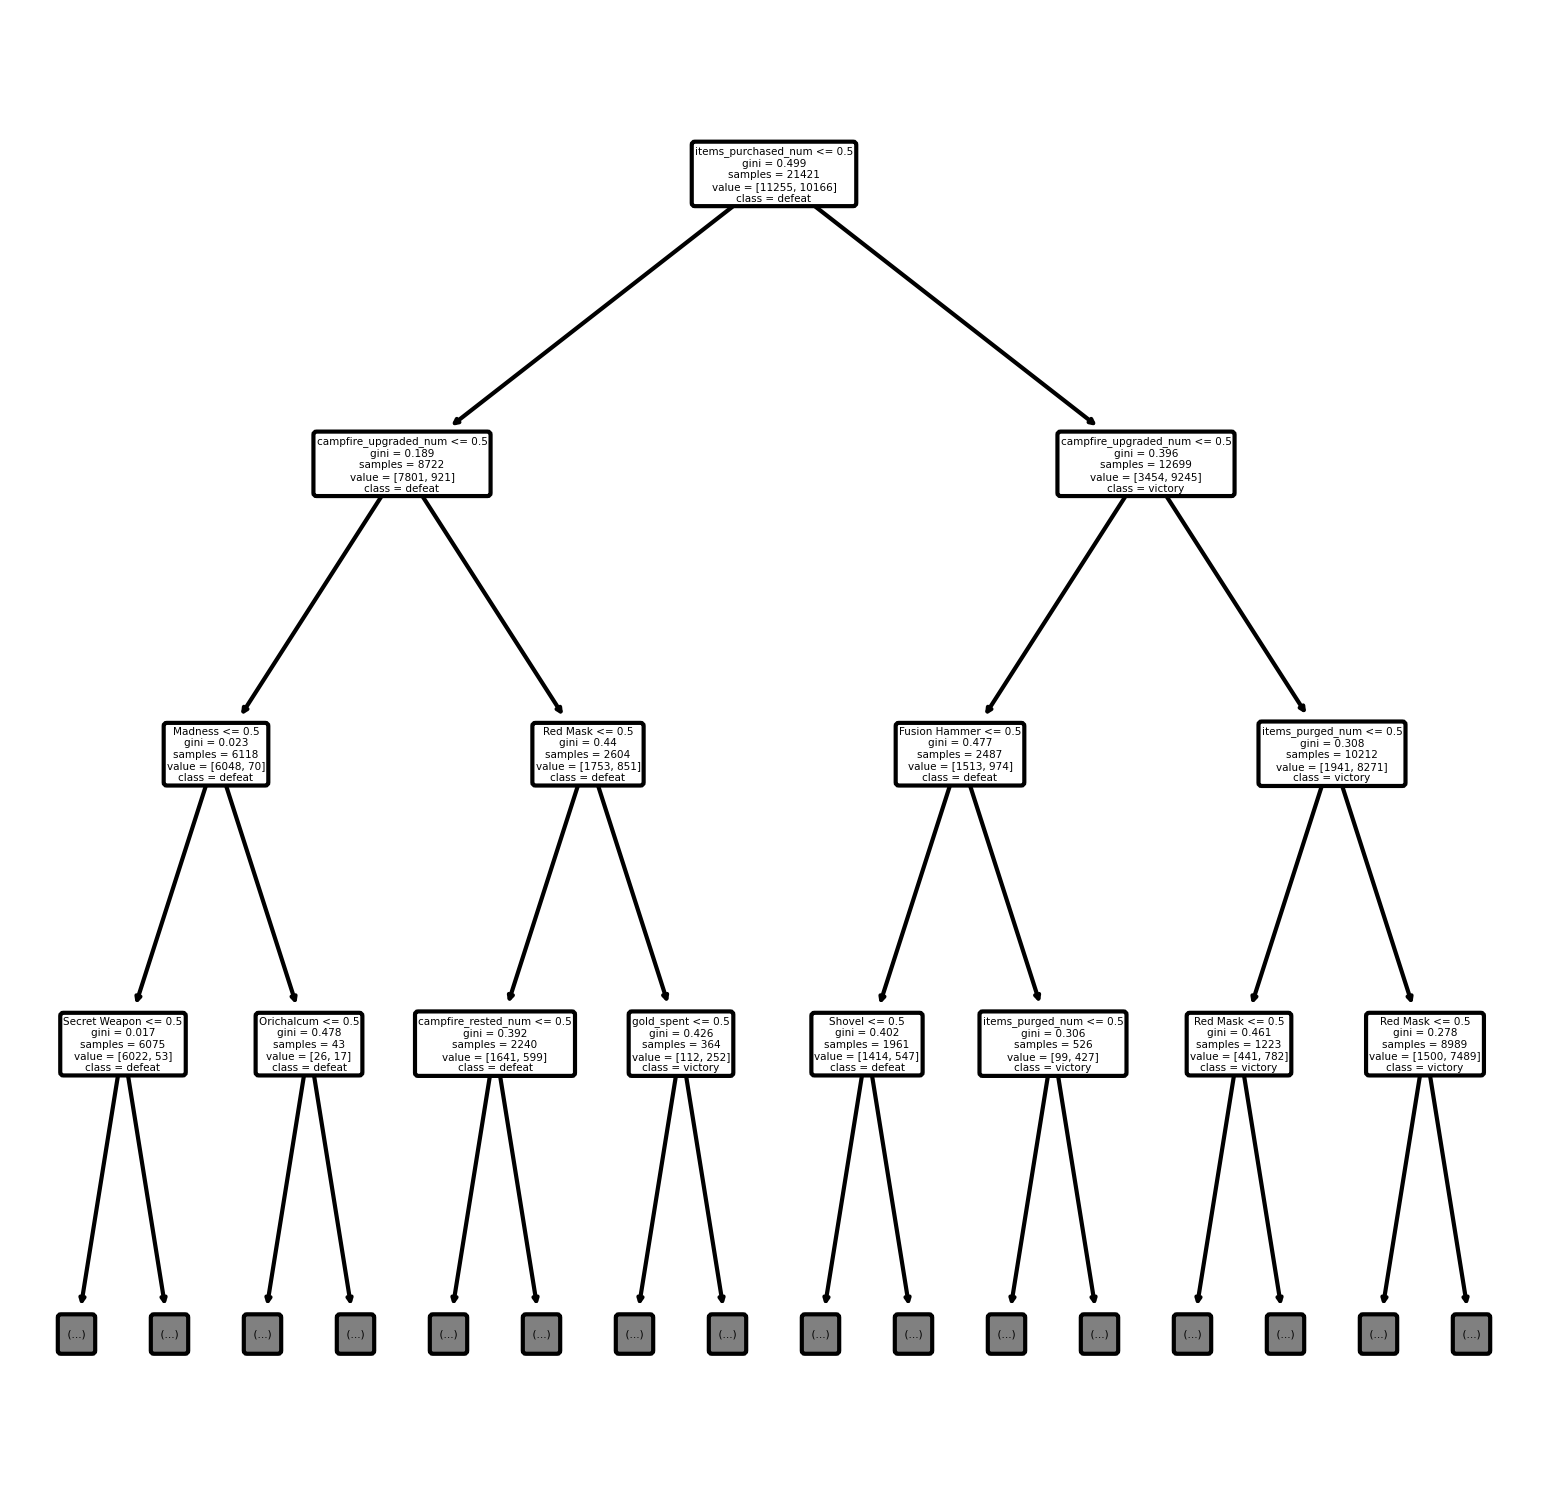

In [36]:
dtc = DecisionTreeClassifier(max_depth=5,random_state=0,min_samples_leaf=1)
dtc.fit(X_tr_lime,y_tr_lime)
print(dtc.score(X_te_lime,y_te_lime))
plt.figure(figsize=(6.4,6.4), dpi=300)
plot_tree(dtc, feature_names=feature_names, max_depth=3, fontsize=2.5, rounded=True, class_names=['defeat','victory'])


In [37]:
plot_confusion_matrix(rf, X_test, y_test, display_labels=['defeat','victory'])

ValueError: Number of features of the model must match the input. Model n_features is 879 and input n_features is 1052 

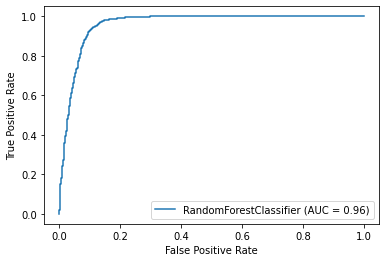

In [ ]:
plot_roc_curve(rf, X_test, y_test)

Uh oh! Imbalanced dataset. Let's take a look at Cohen's kappa score

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import cohen_kappa_score

y_pred = rf.predict(X_test)
y_true = y_test

kappa = cohen_kappa_score(y_pred, y_true)
print('cohen kappa before',kappa)

oversample = SMOTE(random_state=0)
X_smote, y_smote = oversample.fit_resample(X_svm, y)
print(ecs.shape)

X_smote_train, X_smote_test, y_smote_train, y_smote_test = train_test_split(X_smote, y_smote, train_size=0.8, random_state=0)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


cohen kappa before 0.8299702086380524


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


NameError: ignored

In [ ]:
rf_smote = RandomForestClassifier(n_estimators=500,max_depth=5,random_state=0)
rf_smote.fit(X_smote_train, y_smote_train)

y_pred = rf_smote.predict(X_smote_test)
y_true = y_smote_test

kappa = cohen_kappa_score(y_pred, y_true)
print('cohen kappa after',kappa)

print(rf_smote.score(X_smote_test,y_smote_test))

cohen kappa after 0.9276819156769216
0.9641434262948207


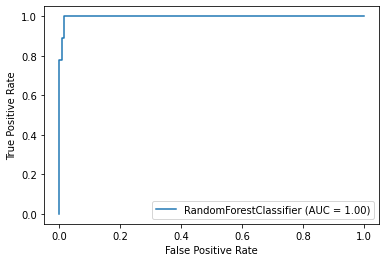

In [ ]:
plot_roc_curve(rf_smote, X_test,y_test)

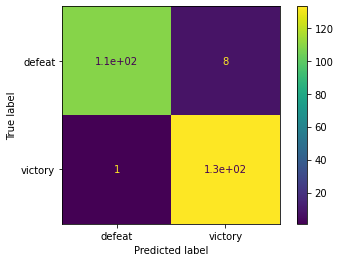

In [ ]:
plot_confusion_matrix(rf_smote, X_smote_test, y_smote_test, display_labels=['defeat','victory'])

Data is ready, look at interaction between features

In [ ]:
!pip install sklearn-gbmi
from sklearn_gbmi import *

h_all_pairs(rf, X_train)

Discretize continuous features for LIME

1.   gold_spent



In [ ]:
explainer = LimeTabularExplainer(training_data=X_train, training_labels=y_train,feature_names=feature_names,discretizer='quartile',class_names=['defeat','victory'])
explanation = explainer.explain_instance(X_test[i], rf.predict_proba, num_features=15)
explanation.show_in_notebook(show_table=True,show_all=False)

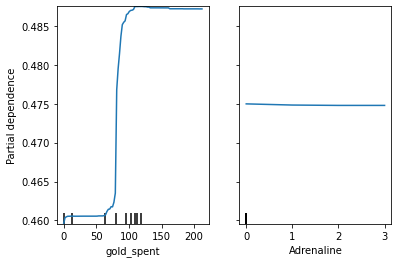

In [ ]:
plot_partial_dependence(rf, X_train, features=['gold_spent','Adrenaline'], feature_names=feature_names)

In [ ]:
!pip install alibi
from alibi.explainers import ALE, plot_ale

ale = ALE(rf.predict_proba, feature_names=feature_names[0], target_names=['defeat','victory'])
proba_exp_rf = ale.explain(X_test)

plot_ale(proba_exp_rf)

In [ ]:
!pip install alepython
from alepython import ale_plot

ale_plot(rf, X_train, 'gold_spent', monte_carlo=True)

Let's try another classifier trained on the features scaled

In [ ]:
X_scale_train, X_scale_test, _, _ = train_test_split(X,y,train_size=0.8,random_state=0)
logreg = LogisticRegression(random_state=0,max_iter=1000)
logreg = logreg.fit(X_scale_train,y_train)
scores = cross_val_score(logreg, X_scale_test, y_test, cv=7)
scores.mean()

0.884267759967423

Weight plot on the logistic regression features

In [ ]:
def weight_plot():
  

What if outcome is better described by Poisson distribution?

In [ ]:
!pip3 install -U scikit-learn
from sklearn.linear_model import PoissonRegressor

In [ ]:
pr_glm = PoissonRegressor(alpha=0.5)
pr_glm.fit(X_train,y_train)
pr_glm.score(X_test,y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_glm/link.py:90: RuntimeWarning: overflow encountered in exp
  return np.exp(lin_pred)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_glm/link.py:93: RuntimeWarning: overflow encountered in exp
  return np.exp(lin_pred)
/usr/local/lib/python3.6/dist-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: invalid value encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/usr/local/lib/python3.6/dist-packages/sklearn/_loss/glm_distribution.py:315: RuntimeWarning: invalid value encountered in add
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
/usr/local/lib/python3.6/dist-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: overflow encountered in multiply
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_glm/glm.py:45: RuntimeWarning: invalid value encountered in matmul
  devp = np.concatenate(([temp.

-3.096909308042406e-05

No, it doesn't seem so...

In [ ]:
!pip install shap
import shap

shap.initjs()

shap_explainer = shap.TreeExplainer(rf)
shap_values = shap_explainer.shap_values(X_train)

print(X_train)

shap.force_plot(1, shap_values[0], X_train[0])